In [1]:
using DrWatson
using GenerativeMIL
using Flux
using Flux3D: chamfer_distance
using MLDataPattern
using ProgressMeter: Progress, next!
using PaddedViews

┌ Info: Precompiling GenerativeMIL [4ec10b0d-33ec-5e6b-88b9-838b82d80493]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [2]:
using Distances

function SumMinDist(A, B)
    # minimum_{j}(|| a_i - b_j||^2)
    # Chamfer Distance between two 2D!! sets / bags / point clouds
    # A ∈ R^{N,D} , B ∈ R^{M,D}
    dist = Distances.pairwise(SqEuclidean(), A, B, dims=1) # -> distance matrix R^{N,M}
    dist = minimum(dist, dims=2) # over j
    return Flux.sum(dist)
end

function ChamferDistanceLoss(x_true, x_pred)
    # x ∈ R ^ {D, Ni, bs}
    if ndims(x_true) == ndims(x_pred) == 3
        total_loss = 0
        bs = size(x_true, 3)
        for i in 1:bs
            dist_to_x = SumMinDist(x_true[:,:,i], x_pred[:,:,i]) 
            dist_to_y = SumMinDist(x_pred[:,:,i], x_true[:,:,i])
            chamfer_instance = dist_to_x + dist_to_y
            total_loss += chamfer_instance
        end
    elseif ndims(x_true) == ndims(x_pred) == 2
        bs = 1
        dist_to_x = SumMinDist(x_true, x_pred) 
        dist_to_y = SumMinDist(x_pred, x_true)
        chamfer_instance = dist_to_x + dist_to_y
        total_loss = chamfer_instance 
    else
        error("Unsupported input sizes!! | x_pred $(size(x_pred)) | x_true $(size(x_true))")
    end
    return total_loss / bs
end

ChamferDistanceLoss (generic function with 1 method)

In [3]:
function loss_f(m::GenerativeMIL.Models.SetVAE, x::AbstractArray{<:Real}, x_mask::AbstractArray{Bool}, β::Float32=0.01f0)
    #encoder
    x1 = m.encoder.expansion(x) .* x_mask
    x1, h_enc1 = m.encoder.layers[1](x1, x_mask)
    x1, h_enc2 = m.encoder.layers[2](x1, x_mask)
    x1, h_enc3 = m.encoder.layers[3](x1, x_mask)
    x1, h_enc4 = m.encoder.layers[4](x1, x_mask)
    
    #println("encoder", x1)
    _, sample_size, bs = size(x_mask)
    z = m.prior(sample_size, bs)
    #println("sampling", z)
    #decoder
    klds = 0
    x1 = m.decoder.expansion(z) .* x_mask
    x1, kld, _,_ = m.decoder.layers[1](x1, h_enc4, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[2](x1, h_enc3, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[3](x1, h_enc2, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[4](x1, h_enc1, x_mask)
    klds += kld
    x1 = m.decoder.reduction(x1) .* x_mask
    #println("decoder", x1)
    #loss = ChamferDistanceLoss(x, x1) + β * klds
    loss = chamfer_distance(x, x1) + β * klds
end

loss_f (generic function with 2 methods)

In [24]:
function transform_batch1(x)
    a_mask = [ones(size(a)) for a in x];
    max_set = minimum(size.(x))[end]; #minimum
    b = map(a->Array(PaddedView(0, a, (3, max_set))), x);
    b_mask = map(a->Array(PaddedView(0, a, (3, max_set))), a_mask);
    c = cat(b..., dims=3);
    c_mask = cat(b_mask..., dims=3) .> 0; # mask as BitArray
    c_mask = Array(c_mask[1:1,:,:]);
    return c, c_mask
end

transform_batch1 (generic function with 1 method)

In [25]:
train, test = GenerativeMIL.Models.load_and_standardize_mnist();

┌ Info: train standardized μ = [14.010735081757533; 13.027597697882937; 174.257433938215;;], σ = [4.270086778902686; 5.572331140597686; 87.89041202121322;;]
└ @ GenerativeMIL.Models F:\AI Center\GenerativeMIL\src\models\utils\dataset.jl:137


In [34]:
dataloader = RandomBatches(train[1], size=32)

RandomBatches(::Vector{Any}, 32, ObsDim.Last())
 Iterator providing Inf batches of size 32

In [35]:
sv = GenerativeMIL.Models.SetVAE(3,64,4,[16,8,4,1], [2,4,8,16], 3, 32);

In [36]:
sv.encoder.layers|>size

(4,)

In [37]:
sv_tmp = deepcopy(sv);
ps = Flux.params(sv);
opt = ADAM()

ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [38]:
#loss, back = Flux.pullback(ps) do 
#    loss_f(sv, x, x_mask, 0f0) 
#end;

In [39]:
#grad = back(1f0);
#Flux.Optimise.update!(opt, ps, grad);

In [40]:
losses = []

Any[]

In [41]:
progress = Progress(1000)
beta = 0.01f0
for (i, batch) in enumerate(dataloader)
    x, x_mask = transform_batch1(batch)#GenerativeMIL.Models.transform_batch(batch)
    x = Float32.(x)
    #println(x|>size, x_mask|>size)
    loss, back = Flux.pullback(ps) do 
        loss_f(sv, x, x_mask, beta) 
    end;
    grad = back(1f0);
    Flux.Optimise.update!(opt, ps, grad);
    #@info "loss = $(loss)"
    push!(losses, loss)
    next!(progress; showvalues=[(:iters, "$(i)/$(1000)"),(:loss, loss)])
    if i == 10000
        beta = 0.01f0
    elseif i ==1000
        break
    end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\ghost_000\.julia\packages\ProgressMeter\sN2xr\src\ProgressMeter.jl:618
Progress: 100%|█████████████████████████████████████████| Time: 0:02:49
  iters:  1000/1000
  loss:   0.5159548032096546


In [14]:
#print(Flux.mean(Flux.params(sv_tmp.encoder).==Flux.params(sv.encoder)))
#print(Flux.mean(Flux.params(sv_tmp.decoder).==Flux.params(sv.decoder)))
#print(Flux.mean(Flux.params(sv_tmp.prior).==Flux.params(sv.prior)))

In [15]:
break

LoadError: syntax: break or continue outside loop

In [42]:
using PyPlot

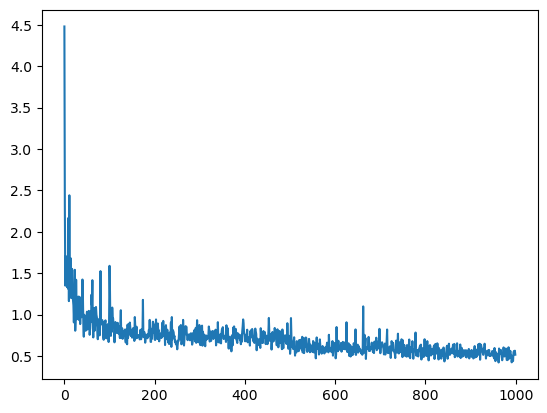

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000002387E20>

In [43]:
plot(losses)

In [55]:
xx = 0
xx_mask = 0
for test in dataloader
    xx, xx_mask = transform_batch1(test)
    xx = Float32.(xx)
    break
end

In [56]:
function forw(m::GenerativeMIL.Models.SetVAE, x::AbstractArray{<:Real}, x_mask::AbstractArray{Bool}, β::Float32=0.01f0)
    #encoder
    x1 = m.encoder.expansion(x) .* x_mask
    x1, h_enc1 = m.encoder.layers[1](x1, x_mask)
    x1, h_enc2 = m.encoder.layers[2](x1, x_mask)
    x1, h_enc3 = m.encoder.layers[3](x1, x_mask)
    x1, h_enc4 = m.encoder.layers[4](x1, x_mask)
    
    _, sample_size, bs = size(x_mask)
    z = m.prior(sample_size, bs)
    
    #decoder
    klds = 0
    x1 = m.decoder.expansion(z) .* x_mask
    x1, kld, _,_ = m.decoder.layers[1](x1, h_enc4, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[2](x1, h_enc3, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[3](x1, h_enc2, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[4](x1, h_enc1, x_mask)
    klds += kld
    x1 = m.decoder.reduction(x1) .* x_mask
    #loss = ChamferDistanceLoss(x, x1) + β * klds
    return x1
end

forw (generic function with 2 methods)

In [57]:
y = forw(sv, xx, xx_mask);

In [58]:
y = y[:,:,1];

In [21]:
losses

Any[]

In [ ]:
using DelimitedFiles
outdata = Dict(:data => losses)
save("losses1.bson", outdata)